In [ ]:
Oracle AI Data Platform v1.0

Copyright © 2025, Oracle and/or its affiliates.

Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl/

# Linear Mixed Effects Model (LME) demo

Here’s a simple yet powerful Linear Mixed Effects Model (LME) demo to showcase AI Data Platform as a data platform for advanced analytics. This demo illustrates how you can use **PySpark**, **pandas**, and **statsmodels** on AI Data Platform for mixed effects modeling.

**Overview of Use Case**

This demos is centered around educational test scores, in the notebook we will analyze test scores of students from multiple schools, accounting for both fixed effects (e.g., gender, study hours) and random effects (e.g., variation between schools).

**Prerequisites**

Install the requirements.txt file to install these libraries on your cluster;

* statsmodels
* seaborn
* pandas
* matplotlib
* numpy==1.26.4



## Load Sample Data

Simulate or load a dataset with repeated measures per group (e.g., students nested within schools).


In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

# Simulate data
n_schools = 10
n_students_per_school = 30

schools = np.repeat([f"School_{i}" for i in range(n_schools)], n_students_per_school)
gender = np.random.choice(["M", "F"], size=n_schools * n_students_per_school)
study_hours = np.random.normal(loc=5, scale=2, size=n_schools * n_students_per_school)
school_effect = np.repeat(np.random.normal(0, 2, n_schools), n_students_per_school)
test_score = 70 + (study_hours * 2) + (gender == "F") * 3 + school_effect + np.random.normal(0, 5, n_schools * n_students_per_school)

df = pd.DataFrame({
    "school": schools,
    "gender": gender,
    "study_hours": study_hours,
    "test_score": test_score
})


## Convert to Spark DataFrame

In [1]:
df_spark = spark.createDataFrame(df)
df_spark.createOrReplaceTempView("student_scores")
df_spark.show()

+--------+------+------------------+-----------------+
| school|gender| study_hours| test_score|
+--------+------+------------------+-----------------+
|School_0| M| 4.615278070437755|83.12206391276042|
|School_0| F| 5.603094684667225|91.71397518095537|
|School_0| M|4.9305764605895135|75.70116364223769|
|School_0| M| 2.662643924760936|79.42017317347324|
|School_0| M| 7.285645629030041|90.52804171626721|
|School_0| F| 6.503866065373549|77.87866272259072|
|School_0| M| 6.582063894086094|77.91246324880248|
|School_0| M| 3.181225090410522|66.83091731597972|
|School_0| M| 7.805588621872198|84.92877109548078|
|School_0| F|2.1962978744154382|81.64493505176986|
|School_0| M| 6.173714187600541| 90.5238416596404|
|School_0| M| 9.380911251619956|89.79692442929797|
|School_0| M|3.0189273497386235| 84.8455604512929|
|School_0| M| 3.867404540794456|71.49892981447363|
|School_0| F| 5.199302730175282|75.54632128753397|
|School_0| M|3.9930486917676014|78.37298691301129|
|School_0| F|1.8986731378677346|79.38230154439118|
|School_0| F| 5.137125949612055|83.77540618271283|
|School_0| F|2.8753925725477902|69.07820266885537|
|School_0| M|5.9471848612703635|82.11339754893596|
+--------+------+------------------+-----------------+
only showing top 20 rows

## Explore with Spark SQL

In [1]:
spark.sql("SELECT school, COUNT(*) as num_students, AVG(test_score) as avg_score FROM student_scores GROUP BY school ORDER BY avg_score DESC").show()


+--------+------------+-----------------+
| school|num_students| avg_score|
+--------+------------+-----------------+
|School_6| 30| 87.7156430596086|
|School_2| 30|84.49452618747813|
|School_7| 30|83.82485081978523|
|School_9| 30| 83.1096218247075|
|School_4| 30|82.92355672883232|
|School_3| 30|81.73362661980572|
|School_5| 30|81.72262202195192|
|School_0| 30|81.10959499701978|
|School_8| 30|80.69379755868701|
|School_1| 30|80.10511942196318|
+--------+------------+-----------------+

## Fit Linear Mixed Effects Model


### First done with Python on Driver node in cluster.

In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Back to pandas for modeling
df_pandas = df_spark.toPandas()

# Fit LME model: test_score ~ study_hours + gender + (1 | school)
model = smf.mixedlm("test_score ~ study_hours + gender", df_pandas, groups=df_pandas["school"])
result = model.fit()

print(result.summary())


Mixed Linear Model Regression Results
========================================================
Model: MixedLM Dependent Variable: test_score
No. Observations: 300 Method: REML 
No. Groups: 10 Scale: 26.4141 
Min. group size: 30 Log-Likelihood: -923.3342 
Max. group size: 30 Converged: Yes 
Mean group size: 30.0 
--------------------------------------------------------
 Coef. Std.Err. z P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept 73.082 1.073 68.108 0.000 70.979 75.186
gender[T.M] -2.308 0.607 -3.800 0.000 -3.499 -1.118
study_hours 2.119 0.155 13.675 0.000 1.815 2.423
Group Var 3.524 0.411 
========================================================

### Then with PySpark.pandas distributed on cluster.

# Visualize the Results with Seaborn



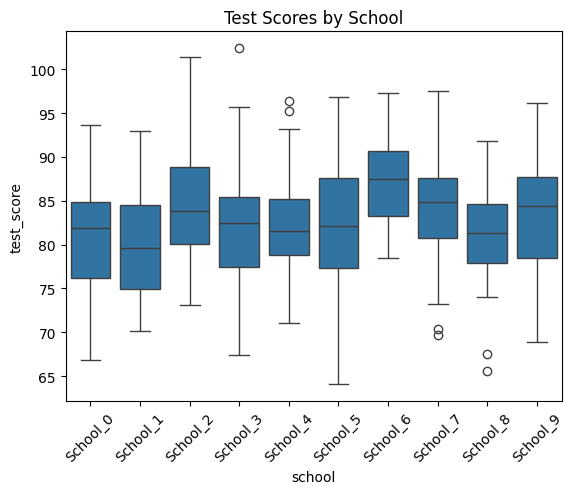

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x="school", y="test_score", data=df_pandas)
plt.xticks(rotation=45)
plt.title("Test Scores by School")
plt.show()
